# King County Home Price Prediction - Regression

King County, Washington is the home of Seattle, a major metropolitan center in the United States. The dataset included various attributes of homes including square footage, number of bathrooms, and grade and using these, the target variable, the price of homes was predicted. Numerous visualizations were utilized to analyze the data to better understand what moves home prices where they are located. Regression models were then constructed and compared to assess which performed the best on conventional metrics to estimate home prices.

1. Import Libraries
2. Exploratory Data Analysis
    1. Interactive Map
    2. Visualizations
        1. Distribution of Price
        2. Scatterplots of Price versus Various Attributes
        3. Median Price Comparison between Highest and Lowest Price Zipcodes
        4. Feature Correlation with Price
        5. Correlation Matrix
    3. Machine Learning Models
        1. Linear Regression
        2. Ridge Regression
        3. Random Forest
        4. CatBoost
        5. Score Comparison
        6. Visualizations of Predictions Agaisnt Test Set

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
import folium
from branca.element import Template, MacroElement
from yellowbrick.target import FeatureCorrelation

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')
import pickle as pkl

### Read Data

In [2]:
df = pd.read_csv('kc_house_data.csv', sep=',')

In [3]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  int64  
 9   view           21597 non-null  int64  
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  int64  
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   21597 non-null  int64  
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

### Exploratory Data Analysis

#### Interactive Map

In [5]:
price_map = df[['price', 'zipcode', 'lat', 'long']]

In [6]:
price_map.head()

,price,zipcode,lat,long
0,221900.0,98178,47.5112,-122.257
1,538000.0,98125,47.7210,-122.319
2,180000.0,98028,47.7379,-122.233
3,604000.0,98136,47.5208,-122.393
4,510000.0,98074,47.6168,-122.045


In [7]:
coord_list = []

for i in range(len(price_map)):
    lat = price_map['lat'].iloc[i]
    long = price_map['long'].iloc[i]
    #coord = [lat, long]
    coord_list.append([lat, long])

price_map['coordinates'] = coord_list
price_map.head()

,price,zipcode,lat,long,coordinates
0,221900.0,98178,47.5112,-122.257,"[47.5112, -122.257]"
1,538000.0,98125,47.7210,-122.319,"[47.721, -122.319]"
2,180000.0,98028,47.7379,-122.233,"[47.7379, -122.233]"
3,604000.0,98136,47.5208,-122.393,"[47.5208, -122.393]"
4,510000.0,98074,47.6168,-122.045,"[47.6168, -122.045]"


In [8]:
price_map['price'].describe()

count    2.159700e+04
mean     5.402966e+05
std      3.673681e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [9]:
q1 = price_map['price'].quantile(0.25)
q2 = price_map['price'].quantile(0.5)
q3 = price_map['price'].quantile(0.75)

price_grade = []

for i in range(len(price_map)):
    if price_map['price'].iloc[i] < q1:
        price_grade.append('low')
    elif price_map['price'].iloc[i] >= q1 and price_map['price'].iloc[i] < q2:
        price_grade.append('medium low')
    elif price_map['price'].iloc[i] >= q2 and price_map['price'].iloc[i] < q3:
        price_grade.append('medium high')
    else:
        price_grade.append('high')

price_map['rank'] = price_grade

price_map.head()

,price,zipcode,lat,long,coordinates,rank
0,221900.0,98178,47.5112,-122.257,"[47.5112, -122.257]",low
1,538000.0,98125,47.7210,-122.319,"[47.721, -122.319]",medium high
2,180000.0,98028,47.7379,-122.233,"[47.7379, -122.233]",low
3,604000.0,98136,47.5208,-122.393,"[47.5208, -122.393]",medium high
4,510000.0,98074,47.6168,-122.045,"[47.6168, -122.045]",medium high


In [10]:
# template for legend on interactive map

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Price Levels</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:red;opacity:0.7;'></span>High</li>
    <li><span style='background:orange;opacity:0.7;'></span>Medium High</li>
    <li><span style='background:blue;opacity:0.7;'></span>Medium Low</li>
    <li><span style='background:purple;opacity:0.7;'></span>Low</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

In [2]:
# interactive map using Folium
"""
title = 'Home Prices in King County, WA'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(title)   


house_map = folium.Map(location=[47.47, -121.84])

homes = folium.map.FeatureGroup()

for i in range(len(price_map)):
    if price_map.iloc[i]['rank'] == 'low':
        color = 'purple'
    elif price_map.iloc[i]['rank'] == 'medium low':
        color = 'blue'
    elif price_map.iloc[i]['rank'] == 'medium high':
        color = 'orange'
    elif price_map.iloc[i]['rank'] == 'high':
        color = 'red'
    popup = 'price: $' + str(int(price_map.iloc[i]['price'])) + '\nlevel: ' + price_map.iloc[i]['rank'] + '\nzipcode: ' + str(price_map.iloc[i]['zipcode'])
    homes.add_child(
        folium.CircleMarker(
            location = price_map.iloc[i]['coordinates'],
            radius=6, 
            color='yellow',
            fill=True,
            fill_color=color, 
            fill_opacity=0.8, 
            popup=popup))
    
house_map.add_child(homes)
house_map.get_root().html.add_child(folium.Element(title_html))
house_map.get_root().add_child(macro)
house_map.save('home_prices_map.html')

house_map
"""

'\ntitle = \'Home Prices in King County, WA\'\ntitle_html = \'\'\'\n             <h3 align="center" style="font-size:16px"><b>{}</b></h3>\n             \'\'\'.format(title)   \n\n\nhouse_map = folium.Map(location=[47.47, -121.84])\n\nhomes = folium.map.FeatureGroup()\n\nfor i in range(len(price_map)):\n    if price_map.iloc[i][\'rank\'] == \'low\':\n        color = \'purple\'\n    elif price_map.iloc[i][\'rank\'] == \'medium low\':\n        color = \'blue\'\n    elif price_map.iloc[i][\'rank\'] == \'medium high\':\n        color = \'orange\'\n    elif price_map.iloc[i][\'rank\'] == \'high\':\n        color = \'red\'\n    popup = \'price: $\' + str(int(price_map.iloc[i][\'price\'])) + \'\nlevel: \' + price_map.iloc[i][\'rank\'] + \'\nzipcode: \' + str(price_map.iloc[i][\'zipcode\'])\n    homes.add_child(\n        folium.CircleMarker(\n            location = price_map.iloc[i][\'coordinates\'],\n            radius=6, \n            color=\'yellow\',\n            fill=True,\n            fil

#### Visualizations 

In [12]:
df.drop(['id', 'date', 'lat', 'long'], axis=1, inplace=True)

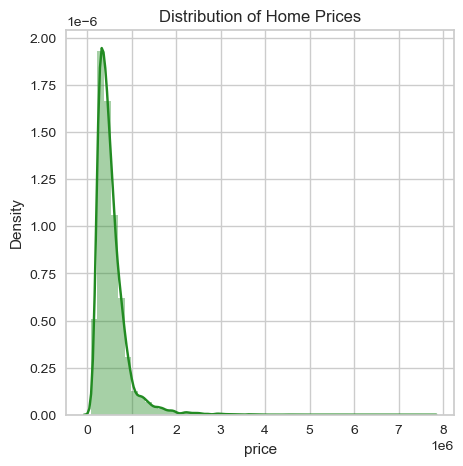

In [13]:
fig = plt.figure(figsize=(5,5))
sns.distplot(df['price'], kde=True, color='forestgreen')
plt.title('Distribution of Home Prices')
plt.show()

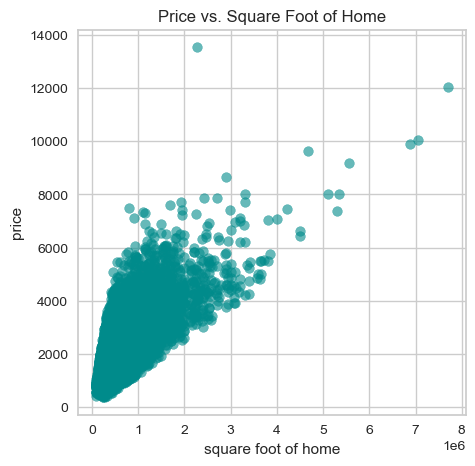

In [14]:
fig = plt.figure(figsize=(5,5))
plt.scatter(df['price'], df['sqft_living'], color='darkcyan', alpha=0.6)
plt.title('Price vs. Square Foot of Home')
plt.xlabel('square foot of home')
plt.ylabel('price')
plt.show()

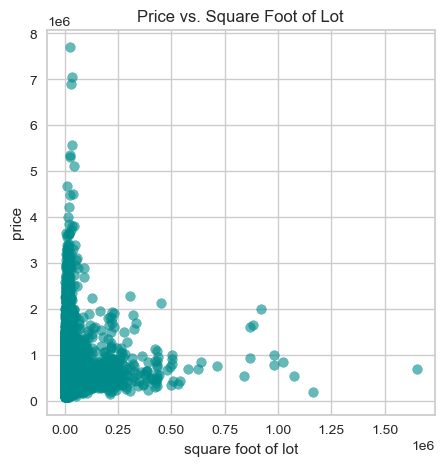

In [15]:
fig = plt.figure(figsize=(5,5))
plt.scatter(df['sqft_lot'], df['price'], color='darkcyan', alpha=0.6)
plt.title('Price vs. Square Foot of Lot')
plt.xlabel('square foot of lot')
plt.ylabel('price')
plt.show()

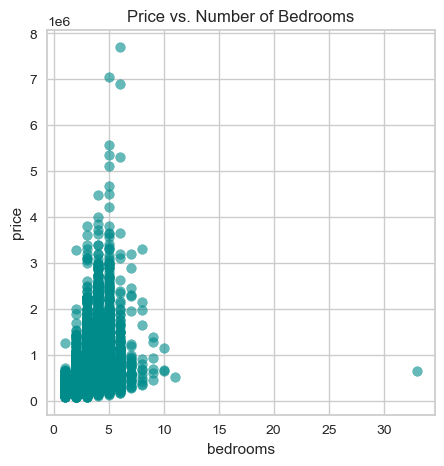

In [16]:
fig = plt.figure(figsize=(5,5))
plt.scatter(df['bedrooms'], df['price'], color='darkcyan', alpha=0.6)
plt.title('Price vs. Number of Bedrooms')
plt.xlabel('bedrooms')
plt.ylabel('price')
plt.show()

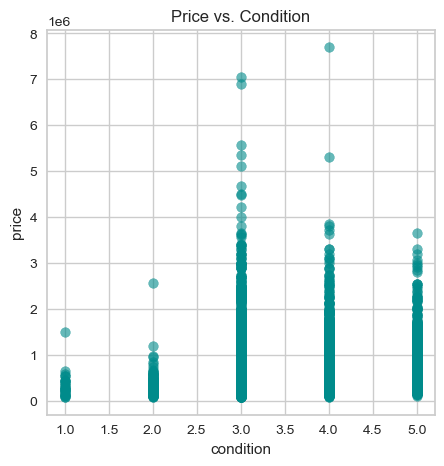

In [17]:
fig = plt.figure(figsize=(5,5))
plt.scatter(df['condition'], df['price'], color='darkcyan', alpha=0.6)
plt.title('Price vs. Condition')
plt.xlabel('condition')
plt.ylabel('price')
plt.show()

In [21]:
zipcodes = df['zipcode'].unique().tolist()
median_price = []

for zipcode in zipcodes:
    median_price.append(np.median(df[df['zipcode'] == zipcode]['price']))

df_zipcode = pd.DataFrame({'zipcode':zipcodes, 'median price':median_price})
top_zipcodes = df_zipcode.sort_values('median price', ascending=False).head(10).reset_index(drop=True)
bottom_zipcodes = df_zipcode.sort_values('median price', ascending=False).tail(10).reset_index(drop=True)

In [22]:
top_zipcodes

,zipcode,median price
0,98039,1895000.0
1,98004,1150000.0
2,98040,993750.0
3,98112,915000.0
4,98005,765475.0
5,98006,760184.5
6,98119,744975.0
7,98075,739999.0
8,98109,736000.0
9,98102,710000.0


In [23]:
bottom_zipcodes

,zipcode,median price
0,98178,278277.0
1,98148,278000.0
2,98023,268450.0
3,98003,267475.0
4,98198,265000.0
5,98188,264000.0
6,98001,260000.0
7,98032,249000.0
8,98002,235000.0
9,98168,235000.0


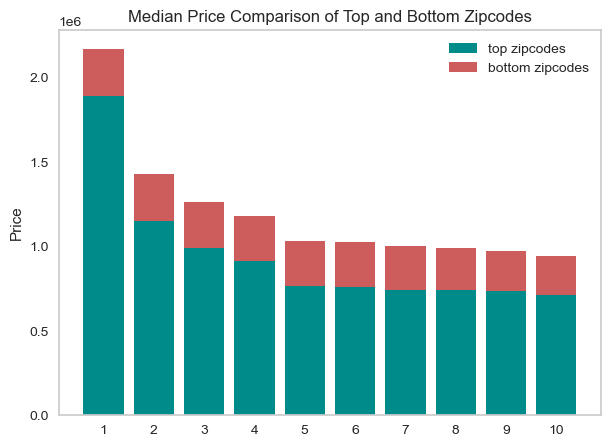

In [24]:
number = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fig = plt.figure(figsize=(7,5))
plt.bar(number, top_zipcodes['median price'], color='darkcyan')
plt.bar(number, bottom_zipcodes['median price'], bottom=top_zipcodes['median price'], color='indianred')
plt.legend(['top zipcodes', 'bottom zipcodes'])
plt.grid(False)
plt.title('Median Price Comparison of Top and Bottom Zipcodes')
plt.xticks(number)
plt.ylabel('Price')
plt.show()

In [25]:
# remove outliers using IQR

Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
 
upper_array = np.where(df['price']>=upper)[0]
lower_array = np.where(df['price']<=lower)[0]
 
df.drop(index=upper_array, inplace=True)
df.drop(index=lower_array, inplace=True)

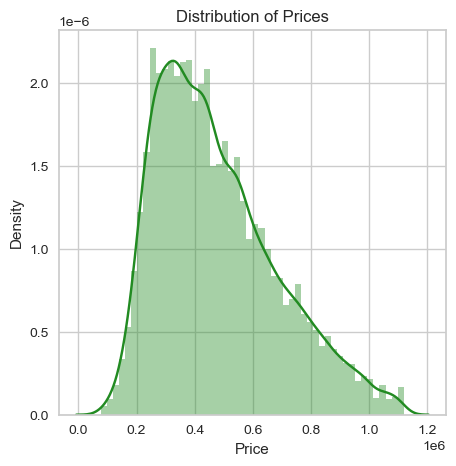

In [26]:
fig = plt.figure(figsize=(5,5))
sns.distplot(df['price'], color='forestgreen')
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.show()

In [27]:
feature_names = df.drop('price', axis=1).columns
numeric_feature_names = df[feature_names].select_dtypes(np.number).columns

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

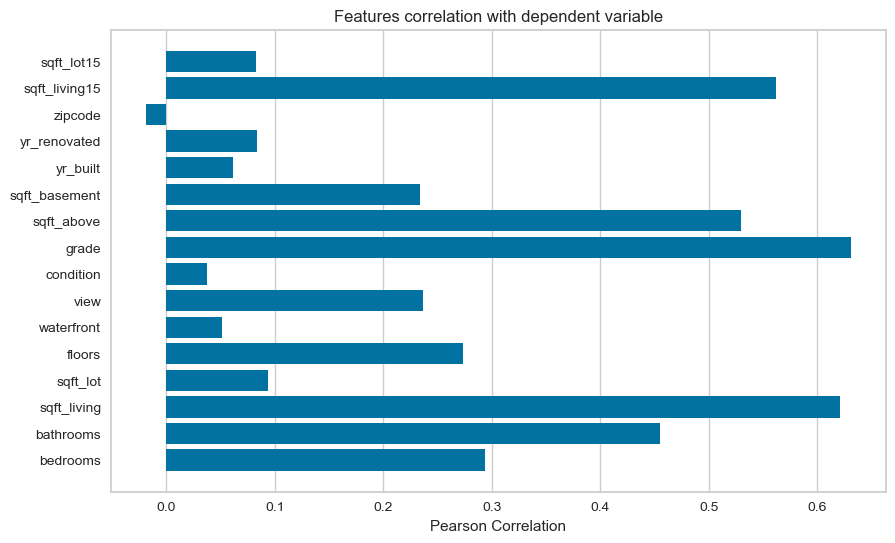

In [28]:
X, y = df[numeric_feature_names], df['price']
features = np.array(numeric_feature_names)
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize'] = (10,6)
visualizer.fit(X, y)
visualizer.show(outpath='price corr.png')

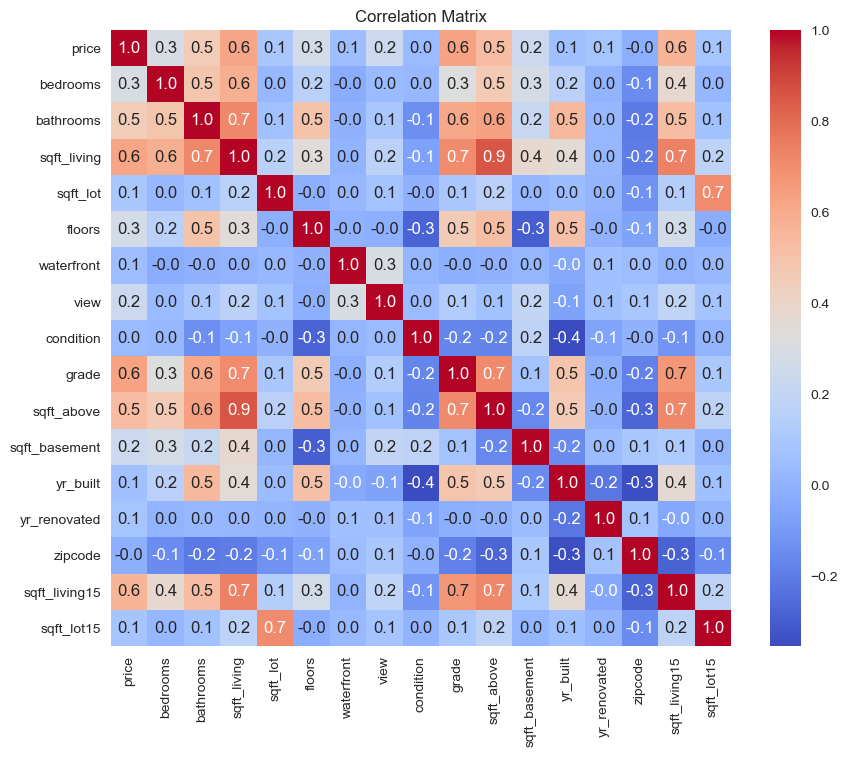

In [29]:
corr_matrix = df.corr()

fig = plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Correlation Matrix')
plt.show()

In [30]:
# log transformation of target variable

df['price'] = np.log1p(df['price'])

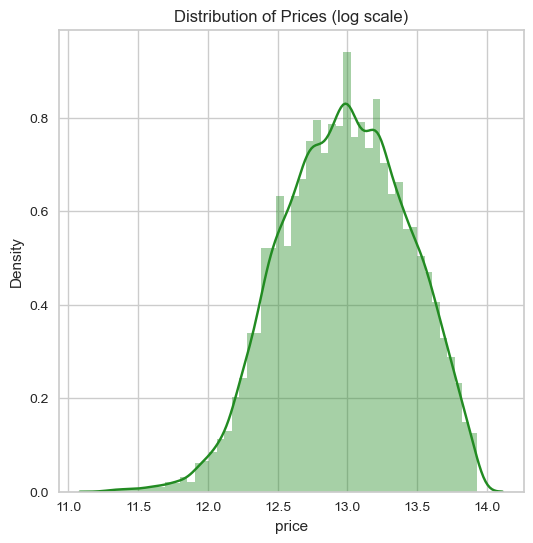

In [31]:
fig = plt.figure(figsize=(6,6))
sns.distplot(df['price'], color='forestgreen')
plt.title('Distribution of Prices (log scale)')
plt.xlabel('price')
plt.show()

### Regression Models

In [32]:
def rmse(y_pred, y_true):
    return np.sqrt(mean_squared_error(y_pred, y_true))

In [33]:
X = df.drop('price', axis=1)
y = df['price']

In [34]:
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,1340,5650
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,1690,7639
2,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,2720,8062
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,1360,5000
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,1800,7503


In [35]:
y.head()

0    12.309987
1    13.195616
2    12.100718
3    13.311331
4    13.142168
Name: price, dtype: float64

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=108)

In [37]:
model_list =[]
r2_list = []
rmse_list = []
mae_list = []

#### Linear Regression

In [38]:
pf = PolynomialFeatures(degree=2)
s = StandardScaler()
lr = LinearRegression()

estimator_lr = Pipeline([('polynomial features', pf), ('scaler', s), ('regression', lr)])

In [39]:
estimator_lr.fit(X_train, y_train)
y_predict_lr = estimator_lr.predict(X_test)

In [40]:
pkl.dump(estimator_lr, open('estimator_lr.pkl', 'wb'))

In [41]:
estimator_lr = pkl.load(open('estimator_lr.pkl', 'rb'))

In [42]:
# zipcode included as int

lr_r2 = r2_score(y_predict_lr, y_test)
lr_rmse = rmse(y_predict_lr, y_test)
lr_mae = mean_absolute_error(y_predict_lr, y_test)
print('R squared score for linear regression:', lr_r2) 
print('RMSE for linear regression:', lr_rmse)
print('MAE for linear regression:', lr_mae)

R squared score for linear regression: 0.3617852585478841
RMSE for linear regression: 0.27903916006425605
MAE for linear regression: 0.21968973626132707


In [43]:
model_list.append('Linear Regression')
r2_list.append(lr_r2)
rmse_list.append(lr_rmse)
mae_list.append(lr_mae)

#### Ridge Regression

In [44]:
pf = PolynomialFeatures(degree=2)
s = StandardScaler()
ridge = Ridge()
estimator_ridge = Pipeline([('polynomial_features', pf), ('scaler', s), ('ridge', ridge)])

alphas1 = np.array([1e-11, 1e-8, 1e-5, 0.001, 0.1])
params_ridge = {'ridge__alpha': alphas1}
grid_ridge = GridSearchCV(estimator_ridge, params_ridge)

In [45]:
grid_ridge.fit(X_train, y_train)
y_predict_ridge = grid_ridge.predict(X_test)

In [46]:
pkl.dump(grid_ridge, open('grid_ridge.pkl', 'wb'))

In [47]:
grid_ridge = pkl.load(open('grid_ridge.pkl', 'rb'))

In [48]:
# scores for ridge grid search

print('Ridge')
print('Best score (rmse):', np.abs(grid_ridge.best_score_))
print('Best parameters', grid_ridge.best_params_)
print('Best estimator: ',grid_ridge.best_estimator_)

Ridge
Best score (rmse): 0.6044712493196146
Best parameters {'ridge__alpha': 1e-08}
Best estimator:  Pipeline(steps=[('polynomial_features', PolynomialFeatures()),
                ('scaler', StandardScaler()), ('ridge', Ridge(alpha=1e-08))])


In [49]:
ridge_r2 = r2_score(y_predict_ridge, y_test)
ridge_rmse = rmse(y_predict_ridge, y_test)
ridge_mae = mean_absolute_error(y_predict_ridge, y_test)

print('R squared score for ridge:', ridge_r2)
print('RMSE for ridge:', ridge_rmse)
print('MAE for ridge:', ridge_mae)

R squared score for ridge: 0.36178446970444167
RMSE for ridge: 0.2790390926831359
MAE for ridge: 0.21968975526195833


In [50]:
model_list.append('Ridge')
r2_list.append(ridge_r2)
rmse_list.append(ridge_rmse)
mae_list.append(ridge_mae)

#### Random Forest Regressor

In [51]:
rf = RandomForestRegressor()

n_estimators = list(np.linspace(200, 2000, 10).astype(int))
max_features = ['auto', 'sqrt']
max_depth = list(np.linspace(10, 110, 11).astype(int))
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, 
                               cv=3, verbose=2, random_state=108, 
                               scoring='neg_root_mean_squared_error', n_jobs=-1)

In [52]:
rf_random.fit(X_train, y_train)
y_pred_rf = rf_random.predict(X_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [53]:
pkl.dump(rf_random, open('rf_random.pkl', 'wb'))

In [54]:
rf_random = pkl.load(open('rf_random.pkl', 'rb'))

In [55]:
print('Random Forest')
print('Best score (rmse):', np.abs(rf_random.best_score_))
print('Best parameters', rf_random.best_params_)
print('Best estimator: ', rf_random.best_estimator_)

Random Forest
Best score (rmse): 0.20792339440462793
Best parameters {'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 110, 'bootstrap': True}
Best estimator:  RandomForestRegressor(max_depth=110, max_features='auto', n_estimators=1600)


In [56]:
rf_r2 = r2_score(y_pred_rf, y_test)
rf_rmse = rmse(y_pred_rf, y_test)
rf_mae = mean_absolute_error(y_pred_rf, y_test)

print('R squared score for random forest:', rf_r2)
print('RMSE for random forest:', rf_rmse)
print('MAE for random forest:', rf_mae)

R squared score for random forest: 0.7384761825549517
RMSE for random forest: 0.19900172152972198
MAE for random forest: 0.14121557838747675


In [57]:
model_list.append('Random Forest')
r2_list.append(rf_r2)
rmse_list.append(rf_rmse)
mae_list.append(rf_mae)

#### CatBoost Regressor

In [58]:
cbr = CatBoostRegressor()

iterations = [100, 150, 200]
learning_rate = [1e-3, 0.01, 0.1, 3, 5]
depth = [2, 4, 6, 8]

param_grid = {'iterations': iterations, 'learning_rate': learning_rate, 'depth': depth}

cbr_grid = GridSearchCV(estimator=cbr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=2, n_jobs=-1, verbose=0)

In [59]:
cbr_grid.fit(X_train, y_train)
y_pred_cbr = cbr_grid.predict(X_test)

0:	learn: 0.4242886	total: 176ms	remaining: 35.1s
1:	learn: 0.4053598	total: 193ms	remaining: 19.1s
2:	learn: 0.3860255	total: 208ms	remaining: 13.6s
3:	learn: 0.3705277	total: 223ms	remaining: 10.9s
4:	learn: 0.3562350	total: 237ms	remaining: 9.25s
5:	learn: 0.3437138	total: 252ms	remaining: 8.15s
6:	learn: 0.3336383	total: 266ms	remaining: 7.33s
7:	learn: 0.3246529	total: 280ms	remaining: 6.71s
8:	learn: 0.3157318	total: 294ms	remaining: 6.24s
9:	learn: 0.3087821	total: 309ms	remaining: 5.87s
10:	learn: 0.3026553	total: 323ms	remaining: 5.55s
11:	learn: 0.2966777	total: 338ms	remaining: 5.3s
12:	learn: 0.2915260	total: 351ms	remaining: 5.05s
13:	learn: 0.2872320	total: 364ms	remaining: 4.83s
14:	learn: 0.2822219	total: 378ms	remaining: 4.66s
15:	learn: 0.2783265	total: 392ms	remaining: 4.5s
16:	learn: 0.2747643	total: 405ms	remaining: 4.36s
17:	learn: 0.2719252	total: 417ms	remaining: 4.22s
18:	learn: 0.2683378	total: 430ms	remaining: 4.1s
19:	learn: 0.2662761	total: 443ms	remaining:

In [60]:
pkl.dump(cbr_grid, open('cbr_grid.pkl', 'wb'))

In [61]:
cbr_grid = pkl.load(open('cbr_grid.pkl', 'rb'))

In [62]:
print('CatBoost')
print('Best score (rmse):', np.abs(cbr_grid.best_score_))
print('Best parameters', cbr_grid.best_params_)
print('Best estimator: ', cbr_grid.best_estimator_)

CatBoost
Best score (rmse): 0.03415503115393388
Best parameters {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}
Best estimator:  <catboost.core.CatBoostRegressor object at 0x000001D912109BE0>


In [63]:
cbr_r2 = r2_score(y_pred_cbr, y_test)
cbr_rmse = rmse(y_pred_cbr, y_test)
cbr_mae = mean_absolute_error(y_pred_cbr, y_test)

print('R squared score for CatBoost:', cbr_r2)
print('RMSE for CatBoost:', cbr_rmse)
print('MAE for CatBoost:', cbr_mae)

R squared score for CatBoost: 0.7973120070421843
RMSE for CatBoost: 0.1762807355091303
MAE for CatBoost: 0.1285876153103175


In [64]:
model_list.append('CatBoost')
r2_list.append(cbr_r2)
rmse_list.append(cbr_rmse)
mae_list.append(cbr_mae)

#### Scores Compared

In [65]:
data = {'model': model_list, 'r2': r2_list, 'rmse': rmse_list, 'mae': mae_list}

scores = pd.DataFrame(data, columns = ['model', 'r2', 'rmse', 'mae'])
scores_styled = scores.style.background_gradient()

In [66]:
scores_styled

,model,r2,rmse,mae
0,Linear Regression,0.361785,0.279039,0.219690
1,Ridge,0.361784,0.279039,0.219690
2,Random Forest,0.738476,0.199002,0.141216
3,CatBoost,0.797312,0.176281,0.128588


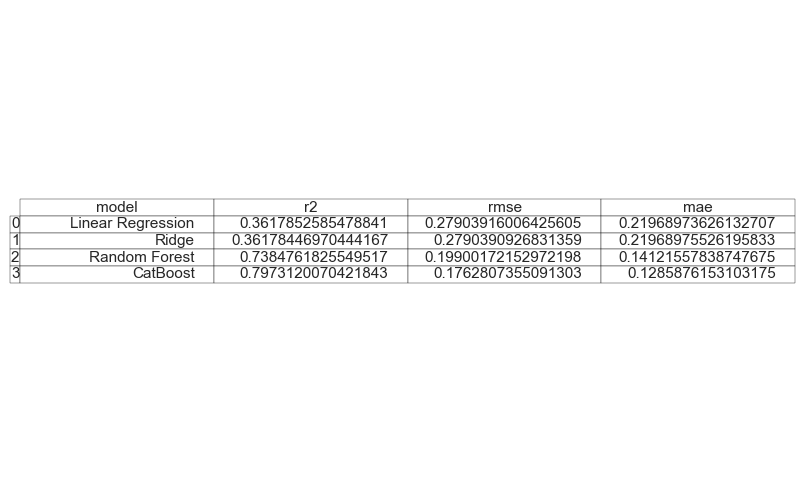

In [67]:
# save scores dataframe to image

ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
table(ax, scores, loc='center') 
plt.savefig('scores.png')

#### Visualizations of Predictions Against Test Set

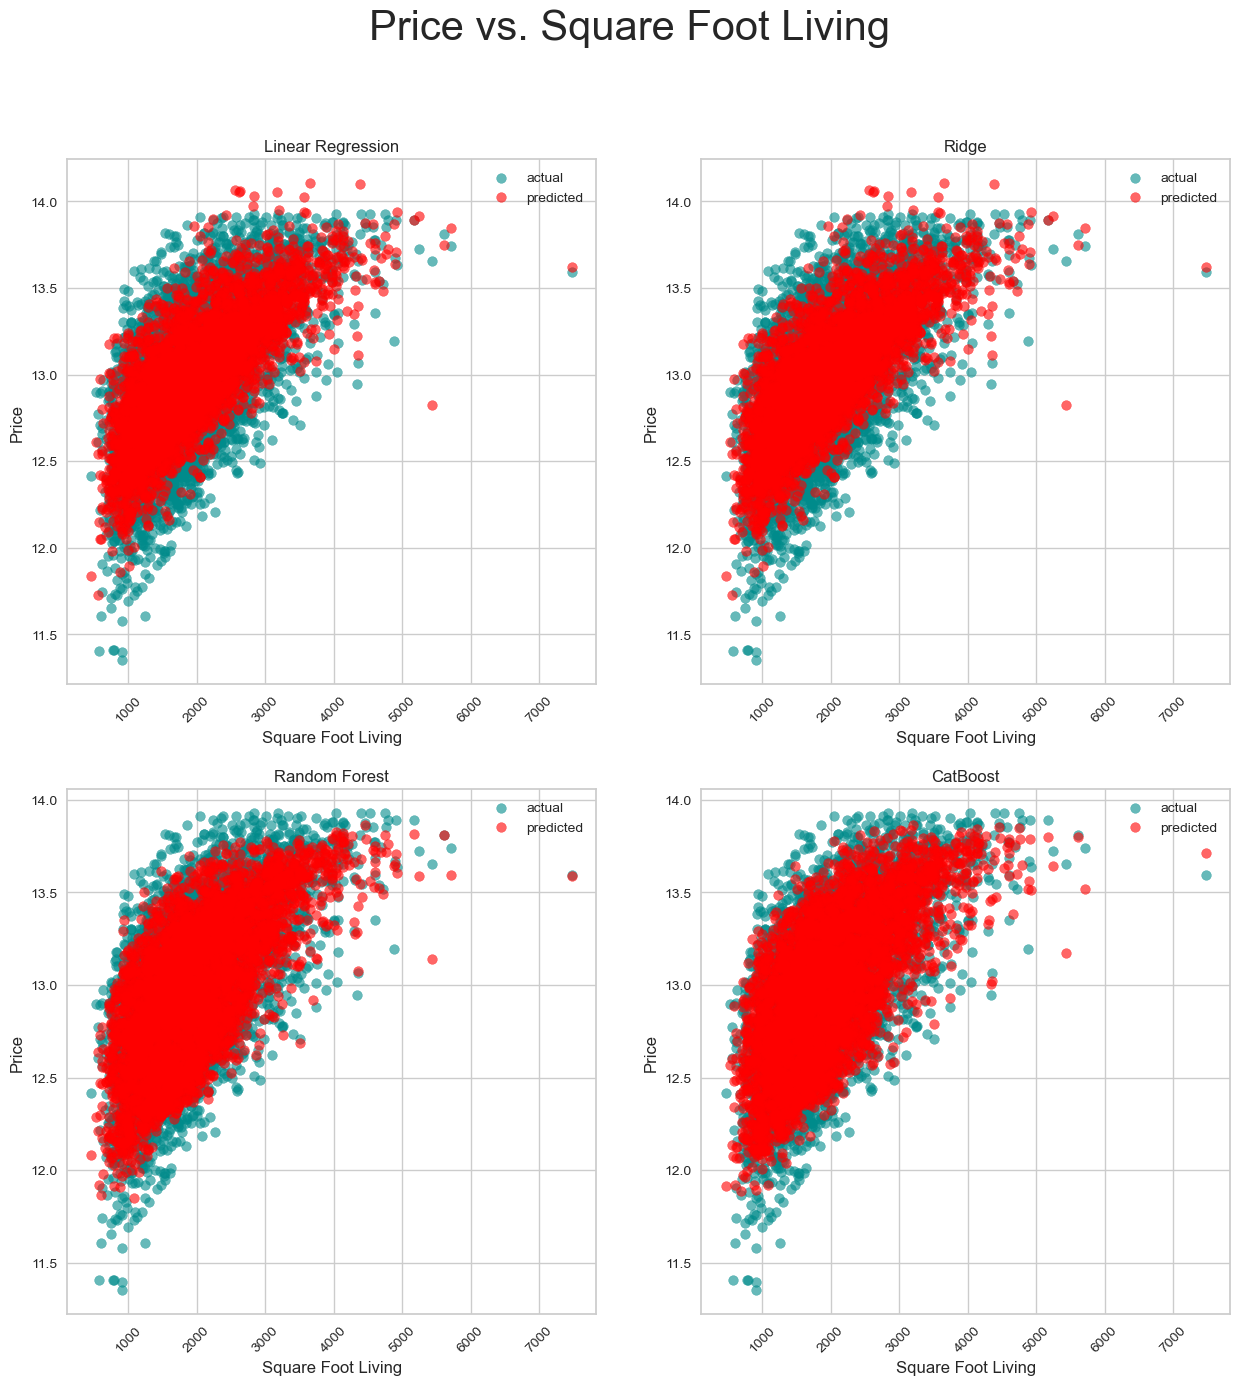

In [68]:
fig = plt.figure(figsize=(15, 15))

plt.subplot(221)
plt.scatter(X_test['sqft_living'], y_test, color='darkcyan', label='actual', alpha=0.6)
plt.scatter(X_test['sqft_living'], y_predict_lr, color='red', label='predicted', alpha=0.6)
plt.title('Linear Regression')
plt.xlabel('Square Foot Living', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend()

plt.subplot(222)
plt.scatter(X_test['sqft_living'], y_test, color='darkcyan', label='actual', alpha=0.6)
plt.scatter(X_test['sqft_living'], y_predict_ridge, color='red', label='predicted', alpha=0.6)
plt.title('Ridge')
plt.xlabel('Square Foot Living', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend()

plt.subplot(223)
plt.scatter(X_test['sqft_living'], y_test, color='darkcyan', label='actual', alpha=0.6)
plt.scatter(X_test['sqft_living'], y_pred_rf, color='red', label='predicted', alpha=0.6)
plt.title('Random Forest')
plt.xlabel('Square Foot Living', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend()

plt.subplot(224)
plt.scatter(X_test['sqft_living'], y_test, color='darkcyan', label='actual', alpha=0.6)
plt.scatter(X_test['sqft_living'], y_pred_cbr, color='red', label='predicted', alpha=0.6)
plt.title('CatBoost')
plt.xlabel('Square Foot Living', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend()

plt.suptitle('Price vs. Square Foot Living', fontsize=30)

plt.show()

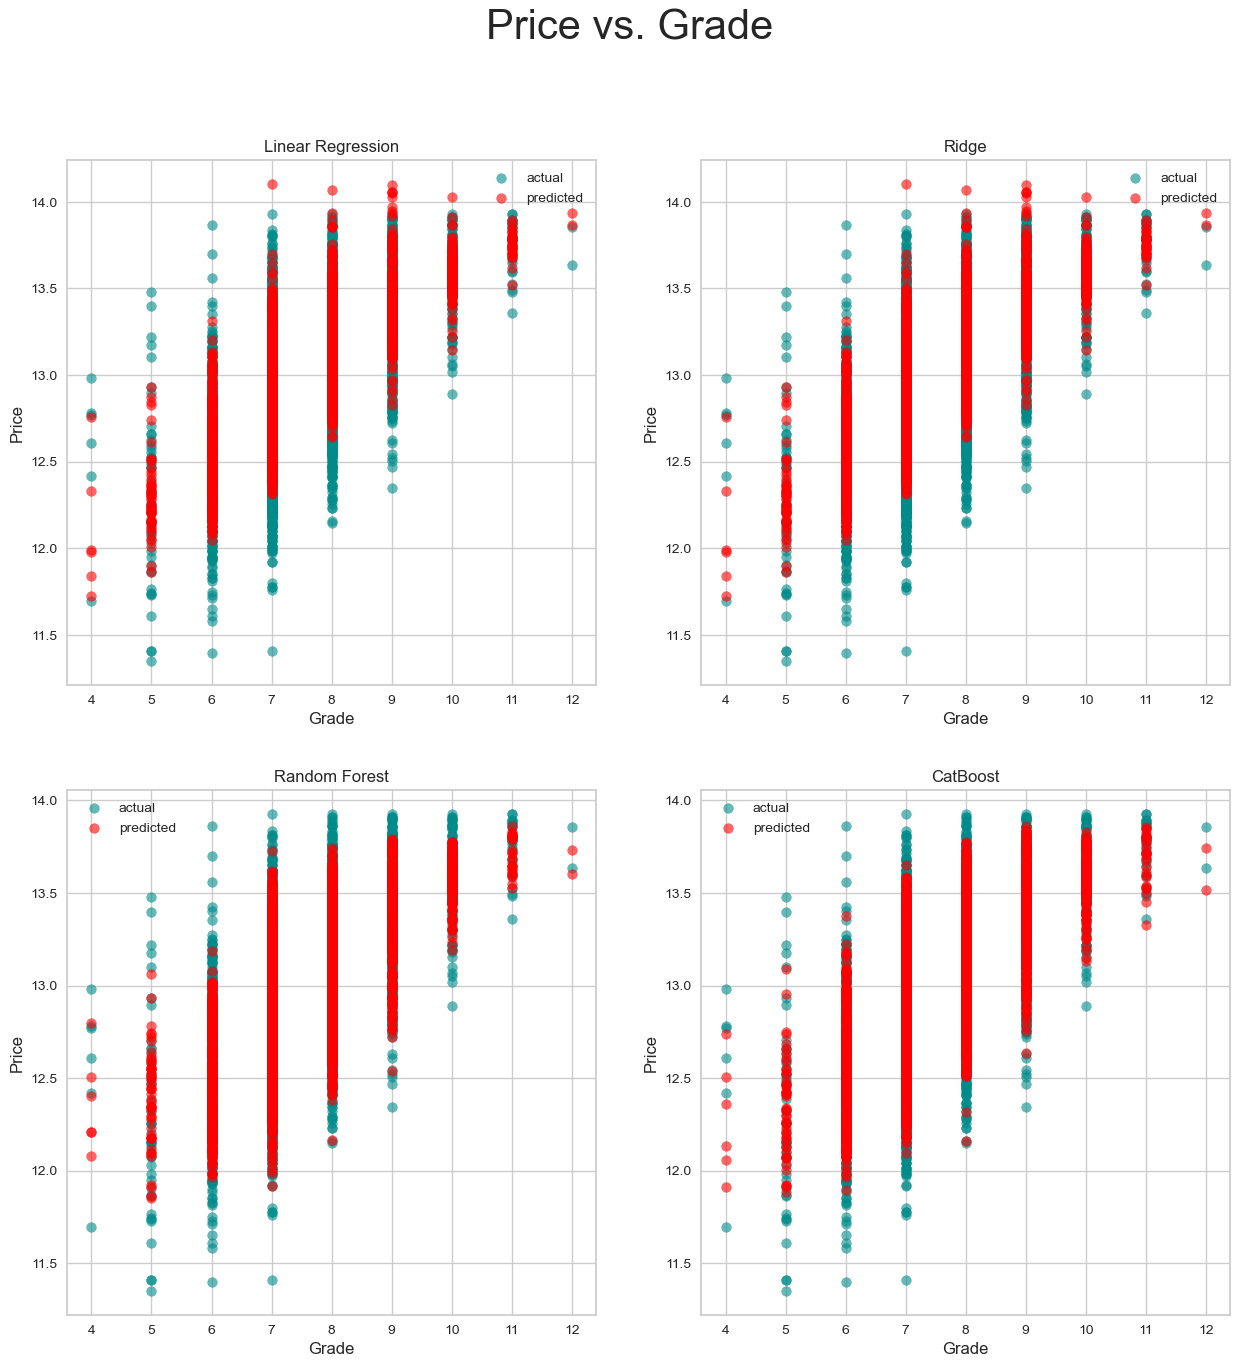

In [69]:
fig = plt.figure(figsize=(15, 15))

plt.subplot(221)
plt.scatter(X_test['grade'], y_test, color='darkcyan', label='actual', alpha=0.6)
plt.scatter(X_test['grade'], y_predict_lr, color='red', label='predicted', alpha=0.6)
plt.title('Linear Regression')
plt.xlabel('Grade', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()

plt.subplot(222)
plt.scatter(X_test['grade'], y_test, color='darkcyan', label='actual', alpha=0.6)
plt.scatter(X_test['grade'], y_predict_ridge, color='red', label='predicted', alpha=0.6)
plt.title('Ridge')
plt.xlabel('Grade', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()

plt.subplot(223)
plt.scatter(X_test['grade'], y_test, color='darkcyan', label='actual', alpha=0.6)
plt.scatter(X_test['grade'], y_pred_rf, color='red', label='predicted', alpha=0.6)
plt.title('Random Forest')
plt.xlabel('Grade', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()

plt.subplot(224)
plt.scatter(X_test['grade'], y_test, color='darkcyan', label='actual', alpha=0.6)
plt.scatter(X_test['grade'], y_pred_cbr, color='red', label='predicted', alpha=0.6)
plt.title('CatBoost')
plt.xlabel('Grade', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()

plt.suptitle('Price vs. Grade', fontsize=30)

plt.show()

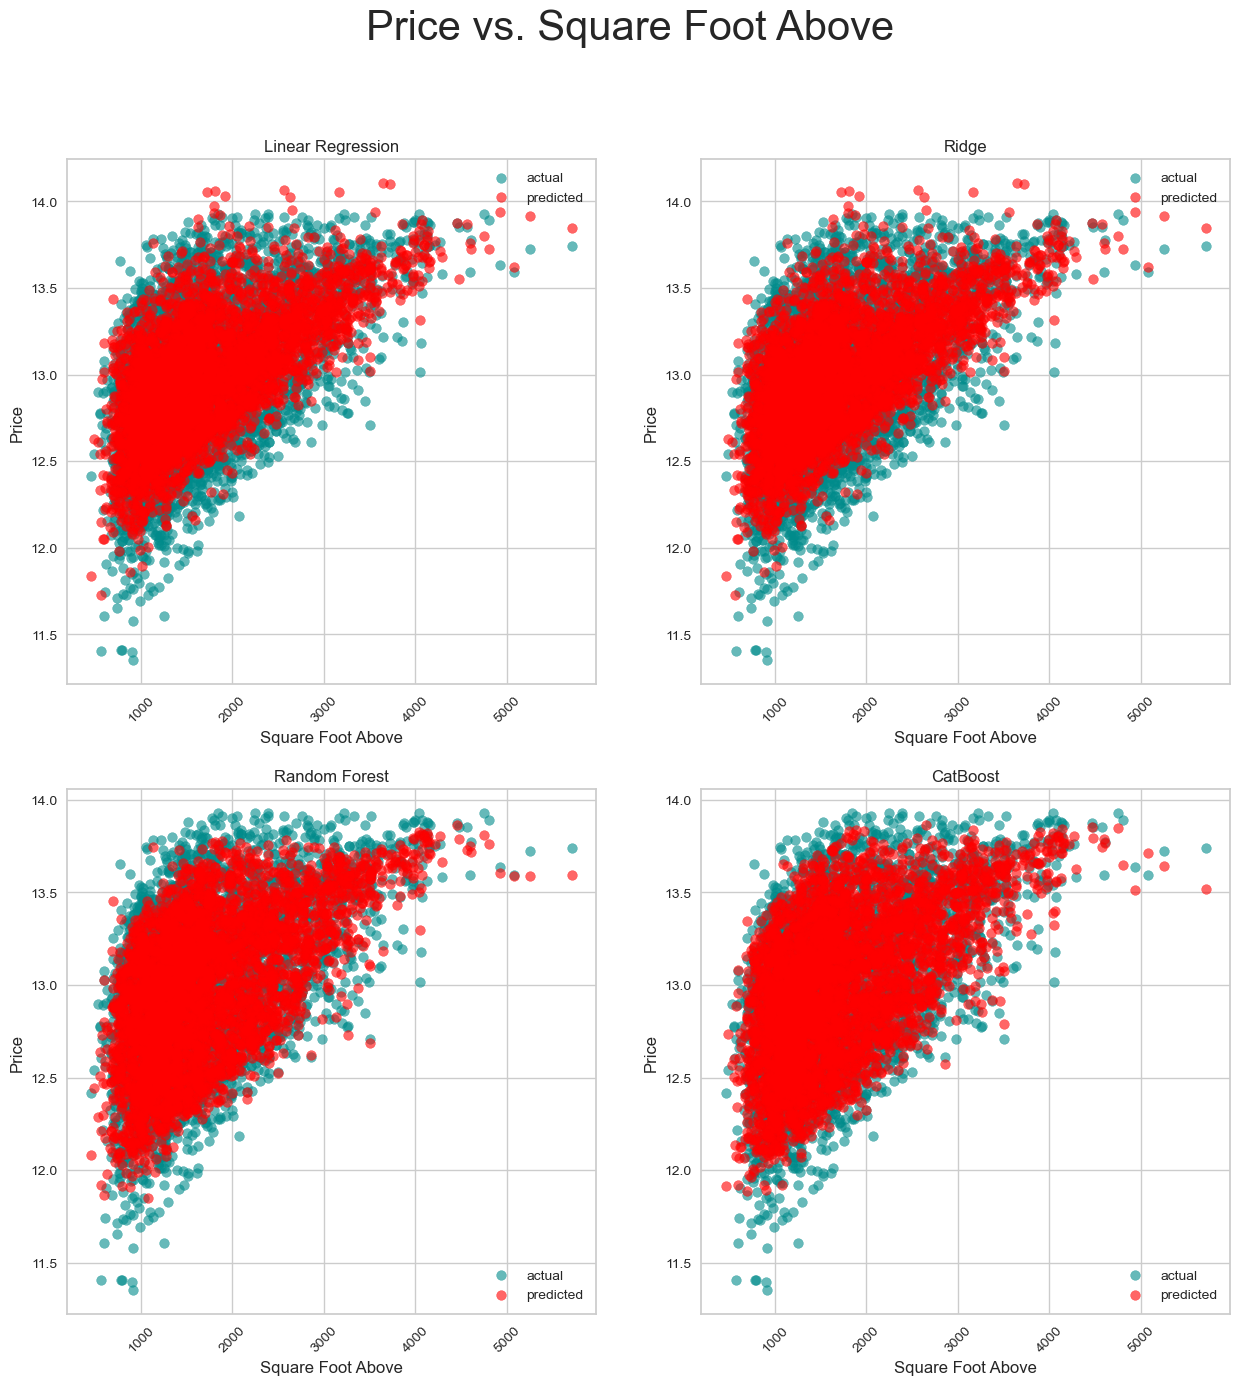

In [70]:
fig = plt.figure(figsize=(15, 15))

plt.subplot(221)
plt.scatter(X_test['sqft_above'], y_test, color='darkcyan', label='actual', alpha=0.6)
plt.scatter(X_test['sqft_above'], y_predict_lr, color='red', label='predicted', alpha=0.6)
plt.title('Linear Regression')
plt.xlabel('Square Foot Above', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend()

plt.subplot(222)
plt.scatter(X_test['sqft_above'], y_test, color='darkcyan', label='actual', alpha=0.6)
plt.scatter(X_test['sqft_above'], y_predict_ridge, color='red', label='predicted', alpha=0.6)
plt.title('Ridge')
plt.xlabel('Square Foot Above', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend()

plt.subplot(223)
plt.scatter(X_test['sqft_above'], y_test, color='darkcyan', label='actual', alpha=0.6)
plt.scatter(X_test['sqft_above'], y_pred_rf, color='red', label='predicted', alpha=0.6)
plt.title('Random Forest')
plt.xlabel('Square Foot Above', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend()

plt.subplot(224)
plt.scatter(X_test['sqft_above'], y_test, color='darkcyan', label='actual', alpha=0.6)
plt.scatter(X_test['sqft_above'], y_pred_cbr, color='red', label='predicted', alpha=0.6)
plt.title('CatBoost')
plt.xlabel('Square Foot Above', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.legend()

plt.suptitle('Price vs. Square Foot Above', fontsize=30)

plt.show()

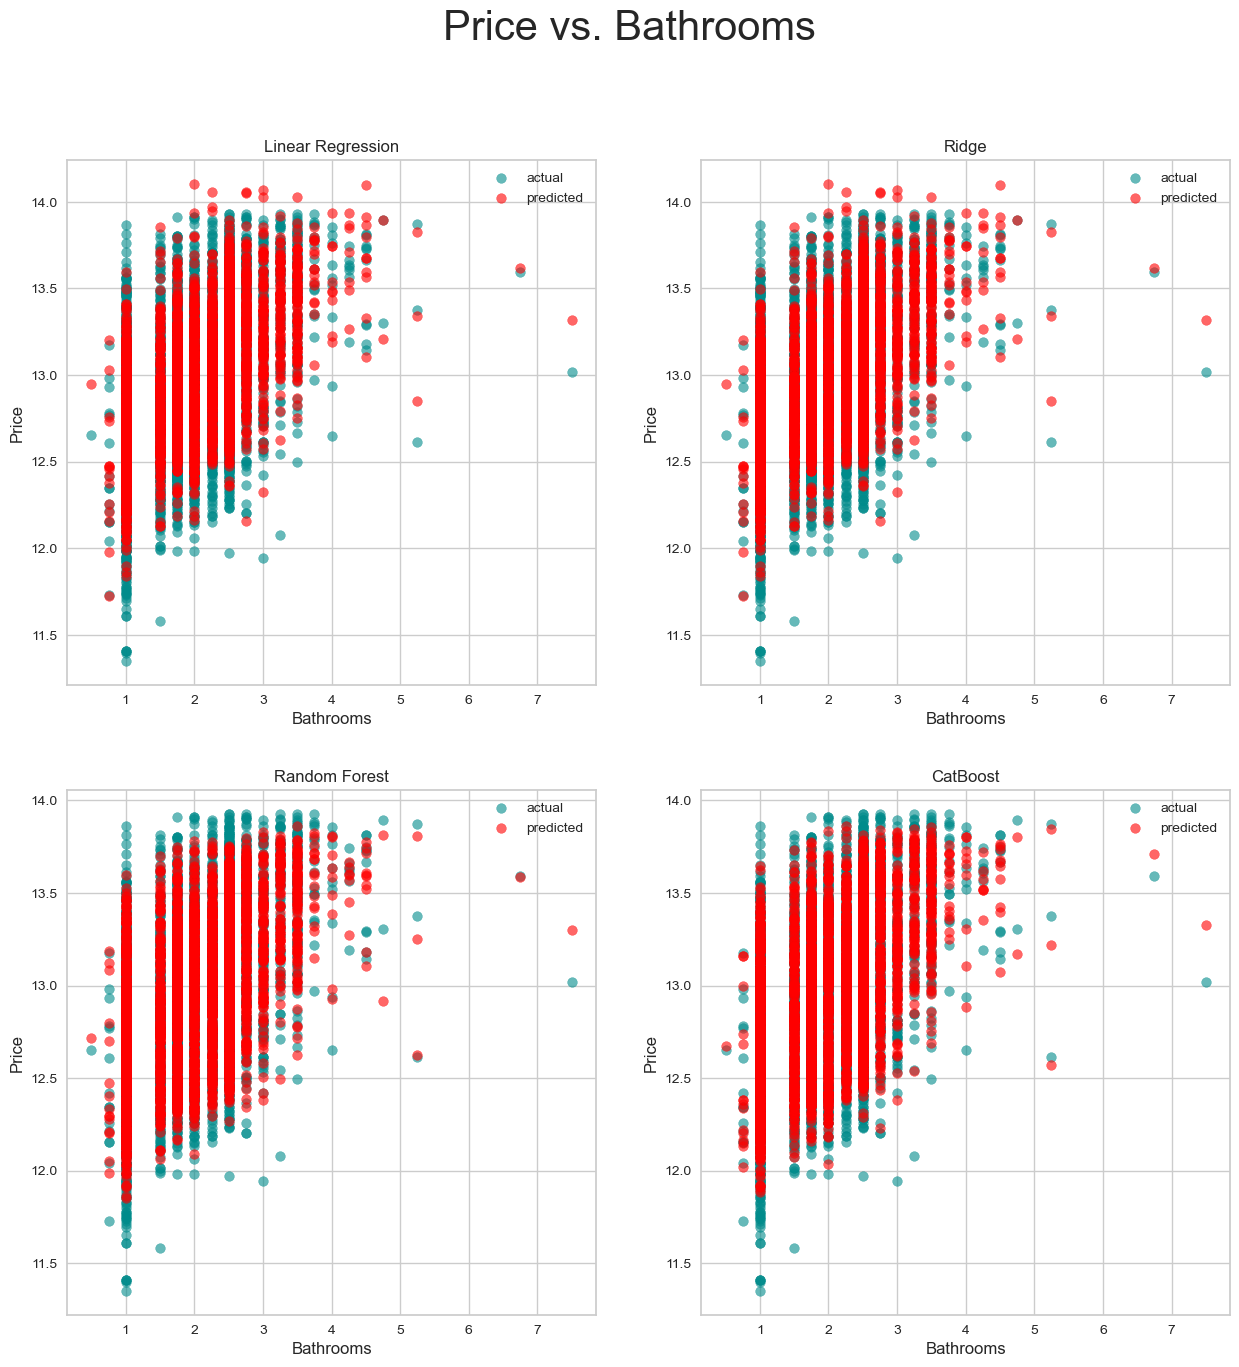

In [71]:
fig = plt.figure(figsize=(15, 15))

plt.subplot(221)
plt.scatter(X_test['bathrooms'], y_test, color='darkcyan', label='actual', alpha=0.6)
plt.scatter(X_test['bathrooms'], y_predict_lr, color='red', label='predicted', alpha=0.6)
plt.title('Linear Regression')
plt.xlabel('Bathrooms', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()

plt.subplot(222)
plt.scatter(X_test['bathrooms'], y_test, color='darkcyan', label='actual', alpha=0.6)
plt.scatter(X_test['bathrooms'], y_predict_ridge, color='red', label='predicted', alpha=0.6)
plt.title('Ridge')
plt.xlabel('Bathrooms', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()

plt.subplot(223)
plt.scatter(X_test['bathrooms'], y_test, color='darkcyan', label='actual', alpha=0.6)
plt.scatter(X_test['bathrooms'], y_pred_rf, color='red', label='predicted', alpha=0.6)
plt.title('Random Forest')
plt.xlabel('Bathrooms', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()

plt.subplot(224)
plt.scatter(X_test['bathrooms'], y_test, color='darkcyan', label='actual', alpha=0.6)
plt.scatter(X_test['bathrooms'], y_pred_cbr, color='red', label='predicted', alpha=0.6)
plt.title('CatBoost')
plt.xlabel('Bathrooms', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()

plt.suptitle('Price vs. Bathrooms', fontsize=30)

plt.show()